In [1]:
import requests
import re
import openai

In [2]:
import pandas as pd

In [62]:
import fitz
doc = fitz.open('bert.pdf')
text = ""
for page in doc:
    text+=page.get_text()
#print(text)

In [63]:
len(text)

64128

In [71]:
df=pd.DataFrame(['0',text]).T

In [72]:
df

,0,1
0,0,BERT: Pre-training of Deep Bidirectional Trans...


<AxesSubplot: >

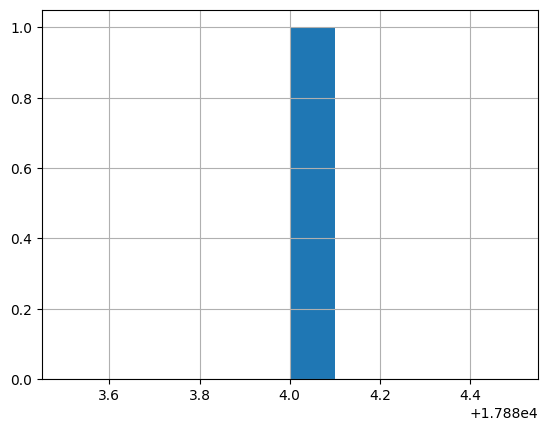

In [73]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

#df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the number of tokens in the entire article 
df.n_tokens.hist()


In [74]:
df.n_tokens

0    17884
Name: n_tokens, dtype: int64

In [ ]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

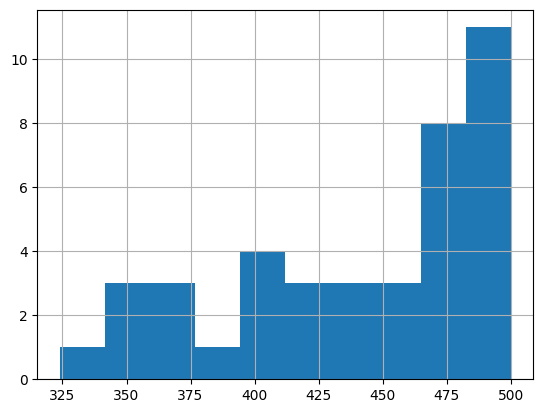

In [16]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [17]:
import openai



In [7]:
openai.api_key ="BLAH"

In [19]:
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,BERT: Pre-training of Deep Bidirectional Trans...,403,"[-0.015882709994912148, -0.010615077801048756,..."
1,These include sentence-level tasks such as\nna...,412,"[-0.020024240016937256, -0.009570907801389694,..."
2,Such re-\nstrictions are sub-optimal for sente...,400,"[-0.021815836429595947, -0.012475931085646152,..."
3,BERT is the ﬁrst ﬁne-\ntuning based representa...,493,"[-0.014375676400959492, -0.013100200332701206,..."
4,They extract\ncontext-sensitive features from ...,348,"[-0.016111504286527634, 0.00792013294994831, 0..."


In [4]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,BERT: Pre-training of Deep Bidirectional Trans...,403,"[-0.015882709994912148, -0.010615077801048756,..."
1,These include sentence-level tasks such as\nna...,412,"[-0.020024240016937256, -0.009570907801389694,..."
2,Such re-\nstrictions are sub-optimal for sente...,400,"[-0.021815836429595947, -0.012475931085646152,..."
3,BERT is the ﬁrst ﬁne-\ntuning based representa...,493,"[-0.014375676400959492, -0.013100200332701206,..."
4,They extract\ncontext-sensitive features from ...,348,"[-0.016111504286527634, 0.00792013294994831, 0..."


In [57]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    question="Am I a monkey?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    prompt = f"""Answer the question as truthfully as possible using the provided text, and if the answer is not contained within the text below, say "I don't know"

    Context:{context}

    Q:{question}
    A:"""
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.ChatCompletion.create(
                        model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}]
        )
        return response['choices'][0]["message"]["content"]
    except Exception as e:
        print(e)
        return ""

In [60]:
res=answer_question(df, question="What is BERT?", debug=False)


In [61]:
res

'BERT stands for Bidirectional Encoder Representations from Transformers, and it is a new language representation model designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. The pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT achieves new state-of-the-art results on eleven natural language processing tasks.'

In [ ]:
#Using A ChatGPT Q&A Specific API 

In [ ]:
import requests

url = "https://chatgpt-powered-question-answering-over-documents.p.rapidapi.com/qa877"

payload = {
	"text": text,
	"query": "Summarize in 3 sentences"
}
headers = {
	"content-type": "application/json",
	"X-RapidAPI-Key": "BLAH",
	"X-RapidAPI-Host": "chatgpt-powered-question-answering-over-documents.p.rapidapi.com"
}

response = requests.request("POST", url, json=payload, headers=headers)

print(response.text)

In [69]:
import requests

url = "https://chatgpt-powered-question-answering-over-documents.p.rapidapi.com/qa877"

payload = {
	"id": "1875011f-1a4e-40af-9b5c-77e6ba1729fd",
	"query": "What is BERT trained on?"
}
headers = {
	"content-type": "application/json",
	"X-RapidAPI-Key": "BLAH",
	"X-RapidAPI-Host": "chatgpt-powered-question-answering-over-documents.p.rapidapi.com"
}

response = requests.request("POST", url, json=payload, headers=headers)

print(response.text)

{
  "answer": "BERT is trained on unlabeled data over different pre-training tasks.",
  "id": "1875011f-1a4e-40af-9b5c-77e6ba1729fd",
  "message": "Successful",
  "status": true
}

